In [201]:
%pylab inline
import keras
import keras.backend as K
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from keras import Input, Model, Sequential
from keras.layers import Lambda, LSTM, RepeatVector, Dense, TimeDistributed, Bidirectional, concatenate,\
Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Activation, Flatten, Reshape
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/ing-luca/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def get_data(data_filepath, timesteps=100, rescale=True):
    def split_data(dataset, timesteps):
        D = dataset.shape[1]
        if D < timesteps:
            return None
        elif D == timesteps:
            return dataset
        else:
            splitted_data, remaining_data = np.hsplit(dataset, [timesteps])
            remaining_data = split_data(remaining_data, timesteps)
            if remaining_data is not None:
                return np.vstack([splitted_data, remaining_data])
            return splitted_data

    data = np.load(data_filepath)
    if rescale:
        percentile_1 = np.percentile(data, 1)
        percentile_99 = np.percentile(data, 99)
        data[data < percentile_1] = percentile_1
        data[data > percentile_99] = percentile_99
        data = MinMaxScaler(feature_range=(-1, 1)).fit_transform(data)
    if timesteps > 0:
        data = split_data(data, timesteps)
    return data

In [112]:
balances_filepath = "../../datasets/berka_dataset/parsed/balances.npy"
transactions_filepath = "../../datasets/berka_dataset/parsed/transactions.npy"

timesteps = 32
transactions = get_data(transactions_filepath, timesteps=timesteps, rescale=True)
np.random.shuffle(transactions)
transactions = transactions[:]
N, D = transactions.shape
print(N, D)

306000 32


# Autoencoders

In [114]:
lr = 0.01
epochs = 1000
loss = 'mse'
latent_dim = 10
lstm_dim = 64
validation_split = 0.3
split_index = N-int(N*validation_split)
optimizer = Adam(lr, epsilon=1e-08, amsgrad=True, clipnorm=1.0)

indexes = np.random.choice(range(split_index, N), 16, replace=False)
early_stopping = EarlyStopping(monitor='loss', min_delta=0.00005, patience=10, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.0005, cooldown=0, min_lr=0)

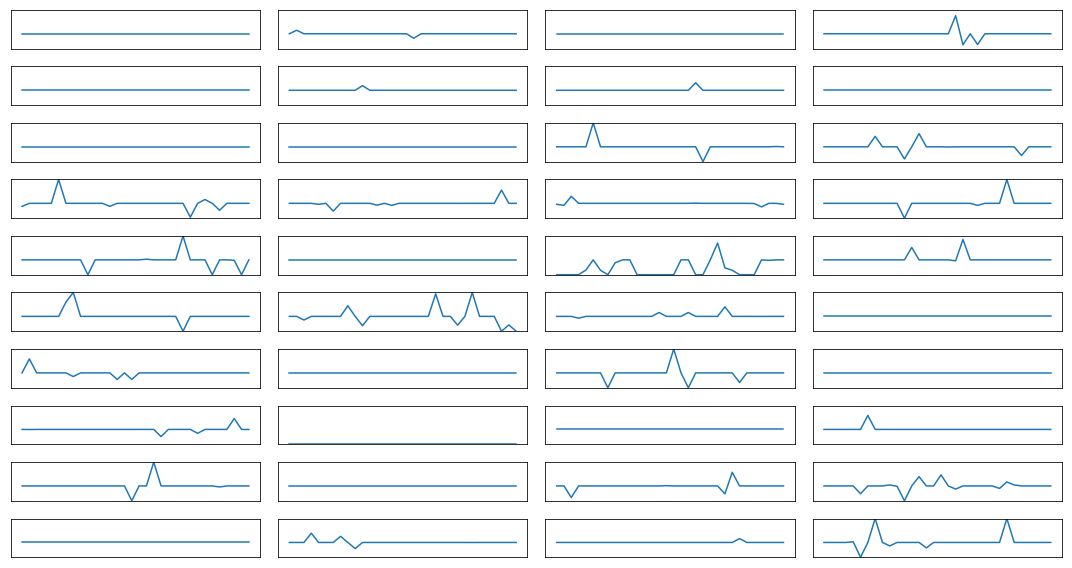

In [115]:
plt.subplots(10, 4, figsize=(15, 8))
for i, index in enumerate(range(0, 4000, 100)):
    plt.subplot(10, 4, i+1)
    plt.plot(transactions[index])
    plt.xticks([])
    plt.yticks([])
    plt.ylim(-1, 1)
    plt.tight_layout()
plt.show()

In [116]:
def plot_predictions(autoencoder, indexes, data, reverse=False, add_timesteps=False):
    plt.subplots(4, 4, figsize=(15, 5))
    steps = np.reshape(np.arange(0, 1, 1/timesteps), (1, timesteps))
    print(steps.shape)
    
    for i, index in enumerate(indexes):
        plt.subplot(4, 4, i+1)
        plt.plot(data[index])
        if reverse:
            if add_timesteps:
                plt.plot((autoencoder.predict([data[index:index+1], steps]).T)[::-1])
            else:
                plt.plot((autoencoder.predict(data[index:index+1]).T)[::-1])
        else:
            if add_timesteps:
                plt.plot(autoencoder.predict([data[index:index+1], steps]).T)
            else:
                plt.plot(autoencoder.predict(data[index:index+1]).T)
        plt.xticks([])
        plt.yticks([])
        plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()
    
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.show()
    
def train_autoencoder(autoencoder, inputs, outputs):
    autoencoder.summary()
    history = autoencoder.fit(inputs, outputs, epochs=epochs, validation_split=validation_split, callbacks=[early_stopping, reduce_lr])
    return history

### Dense-Dense autoencoder

In [ ]:
def get_dense_dense_autoencoder(timesteps, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Dense(latent_dim, activation='tanh', input_shape=(timesteps,)))
    autoencoder.add(Dense(timesteps, activation='tanh'))
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

dense_dense_autoencoder = get_dense_dense_autoencoder(timesteps, latent_dim, loss, lr)
history = train_autoencoder(dense_dense_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(dense_dense_autoencoder, indexes, transactions)

### LSTM-Dense autoencoder

In [ ]:
def get_lstm_dense_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Lambda(lambda x: K.expand_dims(x), input_shape=(timesteps,)))
    autoencoder.add(LSTM(lstm_dim, return_sequences = False))
    autoencoder.add(Dense(latent_dim, activation='tanh'))
    autoencoder.add(Dense(timesteps, activation='tanh'))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

lstm_dense_autoencoder = get_lstm_dense_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(lstm_dense_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(lstm_dense_autoencoder, indexes, transactions)

### Dense-LSTM autoencoder

In [ ]:
def get_dense_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Dense(latent_dim, activation='tanh', input_shape=(timesteps,)))
    autoencoder.add(RepeatVector(timesteps))
    autoencoder.add(LSTM(lstm_dim, return_sequences=True))
    autoencoder.add(TimeDistributed(Dense(1, activation='tanh')))
    autoencoder.add(Lambda(lambda x: K.squeeze(x, -1)))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

dense_lstm_autoencoder = get_dense_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(dense_lstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(dense_lstm_autoencoder, indexes, transactions)

### LSTM-LSTM autoencoder

In [ ]:
def get_lstm_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Lambda(lambda x: K.expand_dims(x), input_shape=(timesteps,)))
    autoencoder.add(LSTM(lstm_dim, return_sequences = False))
    autoencoder.add(Dense(latent_dim, activation='tanh'))
    autoencoder.add(RepeatVector(timesteps))
    autoencoder.add(LSTM(lstm_dim, return_sequences=True))
    autoencoder.add(TimeDistributed(Dense(1, activation='tanh')))
    autoencoder.add(Lambda(lambda x: K.squeeze(x, -1)))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

lstm_lstm_autoencoder = get_lstm_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(lstm_lstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(lstm_lstm_autoencoder, indexes, transactions)

### BLSTM-BLSTM autoencoder

In [ ]:
def get_blstm_blstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr=0.001):
    model_inputs = Input((timesteps,))
    encoder = Lambda(lambda x: K.expand_dims(x))(model_inputs)

    encoder = Bidirectional(LSTM(lstm_dim, return_sequences = False))(encoder)
    encoder = Dense(latent_dim, activation='tanh')(encoder)
    encoder = RepeatVector(timesteps)(encoder)
    
    decoder = Bidirectional(LSTM(lstm_dim, return_sequences=True))(encoder)
    decoder = TimeDistributed(Dense(1, activation='tanh'))(decoder)
    decoder = Lambda(lambda x: K.squeeze(x, -1))(decoder)
    
    autoencoder = Model(model_inputs, decoder)

    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

steps = np.arange(0, 1, 1/timesteps)
steps = np.tile(steps,(transactions.shape[0],1))

blstm_blstm_autoencoder = get_blstm_blstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(blstm_blstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(blstm_blstm_autoencoder, indexes, transactions)

### BLSTM-BLSTM autoencoder (with steps)

In [ ]:
def get_blstm_blstm_steps_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr=0.001):
    model_inputs = Input((timesteps,))
    encoder = Lambda(lambda x: K.expand_dims(x))(model_inputs)

    model_inputs_2 = Input((timesteps,))
    steps = Lambda(lambda x: K.expand_dims(x))(model_inputs_2)

    encoder = Bidirectional(LSTM(lstm_dim, return_sequences = False))(encoder)
    encoder = Dense(latent_dim, activation='tanh')(encoder)
    encoder = RepeatVector(timesteps)(encoder)
    encoder = concatenate([encoder, steps])
    
    decoder = Bidirectional(LSTM(lstm_dim, return_sequences=True))(encoder)
    decoder = TimeDistributed(Dense(1, activation='tanh'))(decoder)
    decoder = Lambda(lambda x: K.squeeze(x, -1))(decoder)
    
    autoencoder = Model([model_inputs, model_inputs_2], decoder)

    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

steps = np.arange(0, 1, 1/timesteps)
steps = np.tile(steps,(transactions.shape[0],1))

blstm_blstm_steps_autoencoder = get_blstm_blstm_steps_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(blstm_blstm_steps_autoencoder, [transactions, steps], transactions)
plot_history(history)
plot_predictions(blstm_blstm_steps_autoencoder, indexes, transactions, add_timesteps=True)

### Conv Conv autoencoder

In [117]:
def get_conv_conv_autoencoder(timesteps, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Lambda(lambda x: K.expand_dims(x), input_shape=(timesteps,)))
    autoencoder.add(Conv1D(32, 5, activation='tanh', padding='same'))
    autoencoder.add(MaxPooling1D(2, padding='same'))
    autoencoder.add(Conv1D(64, 4, activation='tanh', padding='same'))
    autoencoder.add(MaxPooling1D(2, padding='same'))
    autoencoder.add(Conv1D(3, 3, activation='tanh', padding='same'))
    autoencoder.add(MaxPooling1D(2, padding='same'))

    autoencoder.add(Conv1D(3, 3, activation='tanh', padding='same'))
    autoencoder.add(UpSampling1D(2))
    autoencoder.add(Conv1D(64, 4, activation='tanh', padding='same'))
    autoencoder.add(UpSampling1D(2))
    autoencoder.add(Conv1D(32, 5, activation='tanh', padding='same'))
    autoencoder.add(UpSampling1D(2))
    autoencoder.add(Conv1D(1, 3, activation='tanh', padding='same'))
    autoencoder.add(Lambda(lambda x: K.squeeze(x, -1)))
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

conv_conv_autoencoder = get_conv_conv_autoencoder(timesteps, loss, lr)
history = train_autoencoder(conv_conv_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(conv_conv_autoencoder, indexes, transactions)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_68 (Lambda)           (None, 32, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 32)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 64)            8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 3)              579       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 3)              0         
__________

KeyboardInterrupt: 